In [415]:
import numpy as np
import pandas as pd
import pickle   
import random

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

import random
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [416]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [417]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [418]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.01, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))
    
    
    sns.set_style("whitegrid")
    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [419]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [420]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

# Обзор датасетов

In [421]:
TRAIN_DATASET_PATH = '../course_project_train.csv'
TEST_DATASET_PATH = '../course_project_test.csv'

In [422]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [423]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [424]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [425]:
target_name = 'Term'
fuature_names = train_df.columns.drop(target_name).tolist()

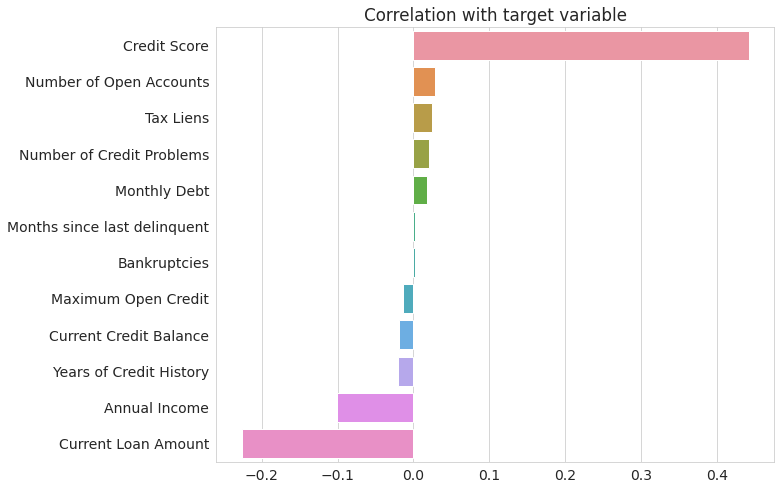

In [426]:
corr_with_target = train_df[fuature_names + [target_name]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [427]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


# Обработка пропусков и выбросов

In [428]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.mean=None
        self.open_quantile = None
        self.annual_quantile = None
        self.short_monthly_debt_mean=None
        self.long_monthly_debt_mean=None
        self.short_loan_amount_mean=None
        self.long_loan_amount_mean=None
        self.ratio_for_short_loan_amount=None
        self.ratio_for_long_loan_amount=None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет констант
        self.medians = X.median()
        self.mean=X.mean()
        self.open_quantile = X['Maximum Open Credit'].quantile(0.99)
        self.annual_quantile = X['Annual Income'].quantile(0.99)
        
        # Расчет коэффициентов для заполнения Current Loan Amount
        df = X.copy()
        df.loc[df['Monthly Debt'] == 0, 'Monthly Debt'] = self.mean['Monthly Debt']
        df.loc[(df['Current Loan Amount'] >=9999999), 'Current Loan Amount'] = np.nan
        self.short_monthly_debt_mean = df.loc[df['Term'] == 'Short Term', 'Monthly Debt'].mean()
        self.long_monthly_debt_mean = df.loc[df['Term'] == 'Long Term', 'Monthly Debt'].mean()
        self.short_loan_amount_mean = df.loc[df['Term'] == 'Short Term', 'Current Loan Amount'].mean()
        self.long_loan_amount_mean = df.loc[df['Term'] == 'Long Term', 'Current Loan Amount'].mean()
        self.ratio_for_short_loan_amount = self.short_loan_amount_mean / self.short_monthly_debt_mean
        self.ratio_for_long_loan_amount = self.long_loan_amount_mean / self.long_monthly_debt_mean
        
        
    def transform(self, X):
        """Трансформация данных"""
        
        # Home Ownership
        X.loc[(X['Home Ownership'] == 'Have Mortgage'), 'Home Ownership'] = 'Home Mortgage'
        
        # Tax Liens
        X.loc[X['Tax Liens'].isin([0.0, 1.0, 6.0, 7.0]), 'Tax Liens'] = 0
        X.loc[(X['Tax Liens'] > 0), 'Tax Liens'] = 1
        X['Tax Liens'] = X['Tax Liens'].astype(int)
        
        # Years in current job
        X.loc[X['Years in current job'].notna(), 'Years in current job'] = 0
        X.loc[X['Years in current job'].isna(), 'Years in current job'] = 1
        X['Years in current job'] = X['Years in current job'].astype(int)
        
        # Term
        X.replace({'Term': {'Short Term': 0, 'Long Term': 1}}, inplace=True)
        X['Term'] = X['Term'].astype(int)
        
        # Monthly Debt
        X.loc[X['Monthly Debt'] == 0, 'Monthly Debt'] = self.mean['Monthly Debt']
        
        
        # Current Loan Amount
        X.loc[(X['Current Loan Amount'] >=9999999), 'Current Loan Amount'] = np.nan
        X.loc[(X['Current Loan Amount'].isna() & (X['Term'] == 0)), 'Current Loan Amount'] = X['Monthly Debt'] * self.ratio_for_short_loan_amount
        X.loc[(X['Current Loan Amount'].isna() & (X['Term'] == 1)), 'Current Loan Amount'] = X['Monthly Debt'] * self.ratio_for_long_loan_amount
        
        
        # Maximum Open Credit
        X.loc[(X['Maximum Open Credit'] < X['Current Loan Amount']), 'Maximum Open Credit'] = X['Current Loan Amount']
        X.loc[(X['Maximum Open Credit'] > self.open_quantile), 'Maximum Open Credit'] = self.mean['Maximum Open Credit']
        X.loc[(X['Maximum Open Credit'] < X['Current Loan Amount']), 'Maximum Open Credit'] = train_df['Current Loan Amount']

        # Bankruptcies
        X.loc[X['Bankruptcies'].isna(), 'Bankruptcies'] = self.mean['Bankruptcies']
        X.loc[(X['Bankruptcies'] > 1), 'Bankruptcies'] = 1      
        
        # Annual Income 
        X.loc[(X['Annual Income'] > self.annual_quantile), 'Annual Income'] = self.mean['Annual Income']
        X['Annual Income outlier'] = 0
        X.loc[X['Annual Income'].isna(), 'Annual Income outlier'] = 1
        X.loc[X['Annual Income'].isna(), 'Annual Income'] = self.mean['Annual Income']
                       
    
        # Number of Open Accounts

           
        # Number of Credit Problems
        
        # Months since last delinquent, предположим, что пропущенные значения - отсутствие проблем с кредитом
        X.loc[X['Months since last delinquent'].isna(), 'Months since last delinquent'] = 0
        
               
        # Current Credit Balance
        
       
        # Credit Score, предположим, что четырехзначные значения - опечатка, разделим на 10
        X.loc[(X['Credit Score'] > 850), 'Credit Score'] = (X['Credit Score'] / 10)
        X['Credit Score outlier'] = 0
        X.loc[X['Credit Score'].isna(), 'Credit Score outlier'] = 1
        X.loc[X['Credit Score'].isna(), 'Credit Score'] = self.mean['Credit Score']      
        
        
        # на всякий случай
        X.fillna(self.medians, inplace=True)
        
        return X   

# Генерация новых признаков

In [429]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):

        self.df=None
        self.purpose_default=None
        self.homeownership=None
        self.delinquent=None
        self.credithistory=None
        self.numberaccounts=None
        self.years_job=None
        self.purpose_default_mean=None
        self.homeownershipmean=None
        self.delinquentmean=None
        self.credithistorymean=None
        self.numberaccountsmean=None
        self.years_job_mean=None
        
        
    def fit(self, X, y=None):
        
        # Расчет переменных для кодирования категориальных признаков через средние значения к целевой переменной
        
        self.df = X.copy()        
        self.credit_default = self.df.groupby('Purpose', as_index=False).agg({'Credit Default':'mean'}).rename(columns={'Credit Default':'CreditDefaultMean'})
        self.credit_default_mean = self.credit_default['CreditDefaultMean'].mean()
        
        self.homeownership = self.df.groupby('Home Ownership', as_index=False).agg({'Credit Default':'mean'}).rename(columns={'Credit Default':'HomeOwnershipMean'})
        self.homeownershipmean = self.homeownership['HomeOwnershipMean'].mean()
        
        self.delinquent = self.df.groupby('Months since last delinquent', as_index=False).agg({'Credit Default':'mean'}).rename(columns={'Credit Default':'delinquentMean'})
        self.delinquentmean = self.delinquent['delinquentMean'].mean()
        
        self.credithistory = self.df.groupby('Years of Credit History', as_index=False).agg({'Credit Default':'mean'}).rename(columns={'Credit Default':'CreditHistoryMean'})
        self.credithistorymean = self.credithistory['CreditHistoryMean'].mean()
        
        self.numberaccounts = self.df.groupby('Number of Open Accounts', as_index=False).agg({'Credit Default':'mean'}).rename(columns={'Credit Default':'NumberAccountsMean'})
        self.numberaccountsmean = self.numberaccounts['NumberAccountsMean'].mean()
        
        self.years_job = self.df.groupby('Years in current job', as_index=False).agg({'Credit Default':'mean'}).rename(columns={'Credit Default':'Years_job_Mean'})
        self.years_job_mean = self.years_job['Years_job_Mean'].mean()
                     
            
    def transform(self, X):
        
       
        # Annual Income / Monthly Debt
        X['Income_to_Debt'] = (X['Monthly Debt'] * 12) / X['Annual Income']
        
        # Current Credit Balance / Current Loan Amount
        X['Credit_to_Loan_Amount'] = X['Current Credit Balance'] / X['Current Loan Amount']
        
        # Annual Income / Current Loan Amount
        X['Annual_to_Loan'] = X['Annual Income'] / X['Current Loan Amount']
        
        # # Current Credit Balance - Monthly Debt
        X['Credit_to_Debt'] = X['Current Credit Balance'] - X['Monthly Debt']
        
        # Кодирование категориальных признаков через средние значения к целевой переменной        
        X = X.merge(self.credit_default, on=['Purpose'], how='left')
        X.fillna(self.credit_default_mean, inplace=True)
            
        X = X.merge(self.homeownership, on=['Home Ownership'], how='left')
        X.fillna(self.homeownershipmean, inplace=True)
        
        X = X.merge(self.delinquent, on=['Months since last delinquent'], how='left')
        X.fillna(self.delinquentmean, inplace=True)
        
        X = X.merge(self.credithistory, on=['Years of Credit History'], how='left')
        X.fillna(self.credithistorymean, inplace=True)
        
        X = X.merge(self.numberaccounts, on=['Number of Open Accounts'], how='left')
        X.fillna(self.numberaccountsmean, inplace=True)
        
        X = X.merge(self.years_job, on=['Years in current job'], how='left')
        X.fillna(self.years_job_mean, inplace=True)
        
        # Удаление категориальных признаков
        X.drop(['Purpose', 'Months since last delinquent', 'Years of Credit History', 'Number of Open Accounts', 'Years in current job'], axis=1, inplace=True)

        
        # на всякий случай
        X = pd.get_dummies(X)

        
        return X

In [430]:
preprocessor = DataPreprocessing()
preprocessor.fit(train_df)

train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

train_df.shape, test_df.shape

((7500, 19), (2500, 18))

In [431]:
features_gen = FeatureGenetator()
features_gen.fit(train_df)

train_df = features_gen.transform(train_df)
test_df = features_gen.transform(test_df)

train_df.shape, test_df.shape

((7500, 26), (2500, 25))

# Отбор признаков

In [432]:
feature_names = ['Annual Income', 
                 'Maximum Open Credit', 'Current Credit Balance',
                 'Current Loan Amount', 'Term',
                 'Monthly Debt', 'Credit Score']
new_feature_names = ['Income_to_Debt', 'Credit_to_Debt', 'Annual_to_Loan', 'Credit_to_Loan_Amount', 'CreditDefaultMean', 'HomeOwnershipMean', 'delinquentMean', 'CreditHistoryMean', 'NumberAccountsMean', 'Years_job_Mean']
target_name = 'Credit Default'

In [433]:
feature_names_for_scaled = ['Annual Income', 'Maximum Open Credit', 'Current Loan Amount', 
                         'Current Credit Balance', 'Monthly Debt', 'Credit Score', 
                         'Income_to_Debt', 'Credit_to_Debt', 'Annual_to_Loan', 'Credit_to_Loan_Amount']

# Балансировка классов

In [434]:
X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [435]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=21)

In [436]:
scaler = StandardScaler()

train_df_scaled = X_train.copy()
valid_df_scaled = X_test.copy()
test_df_scaled = test_df.copy()

train_df_scaled[feature_names_for_scaled] = scaler.fit_transform(train_df_scaled[feature_names_for_scaled])
valid_df_scaled[feature_names_for_scaled] = scaler.transform(valid_df_scaled[feature_names_for_scaled])
test_df_scaled[feature_names_for_scaled] = scaler.transform(test_df_scaled[feature_names_for_scaled])

X_train = train_df_scaled.copy()
X_test = valid_df_scaled.copy()
test_df = test_df_scaled.copy()

In [437]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, target_name)
    
df_balanced[target_name].value_counts()

0    4046
1    3158
Name: Credit Default, dtype: int64

In [438]:
X_train = df_balanced.drop(columns=target_name)
y_train = df_balanced[target_name]

In [439]:
X_train = X_train[feature_names + new_feature_names]
X_test = X_test[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [440]:
X_train.isna().sum().sum(), X_test.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

# Построение и оценка модели


In [441]:
%%time

final_model = lgbm.LGBMClassifier(n_estimators=1000, max_depth=3, learning_rate=0.01,
                                     random_state=21, min_child_samples=50,
                                  class_weight='balanced', reg_alpha=1.0)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.77      0.71      0.74      4046
           1       0.66      0.73      0.70      3158

    accuracy                           0.72      7204
   macro avg       0.72      0.72      0.72      7204
weighted avg       0.73      0.72      0.72      7204

TEST

              precision    recall  f1-score   support

           0       0.83      0.69      0.75      1341
           1       0.45      0.64      0.53       534

    accuracy                           0.68      1875
   macro avg       0.64      0.67      0.64      1875
weighted avg       0.72      0.68      0.69      1875

CONFUSION MATRIX

col_0             0    1
Credit Default          
0               926  415
1               192  342
CPU times: user 3.57 s, sys: 55.9 ms, total: 3.62 s
Wall time: 952 ms


**на несбалансированных данных переобучение в пределах 5%**

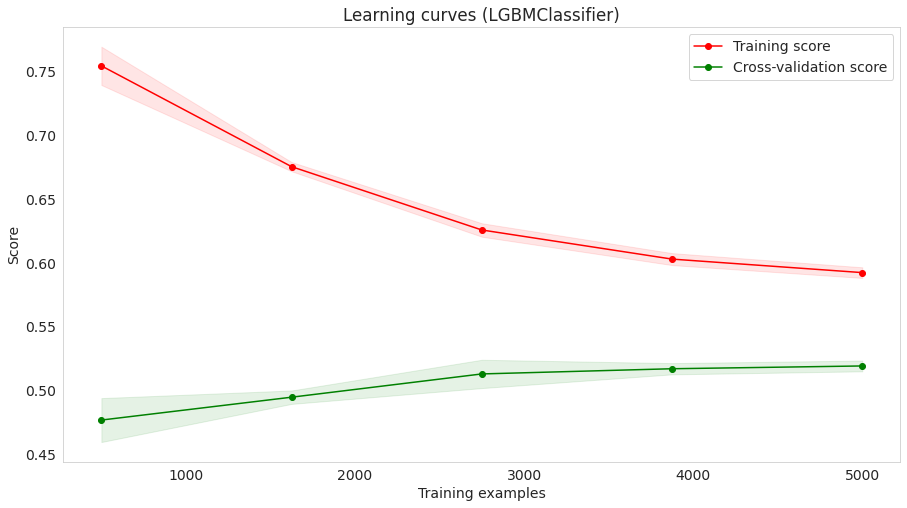

In [442]:
show_learning_curve_plot(final_model, X, y)

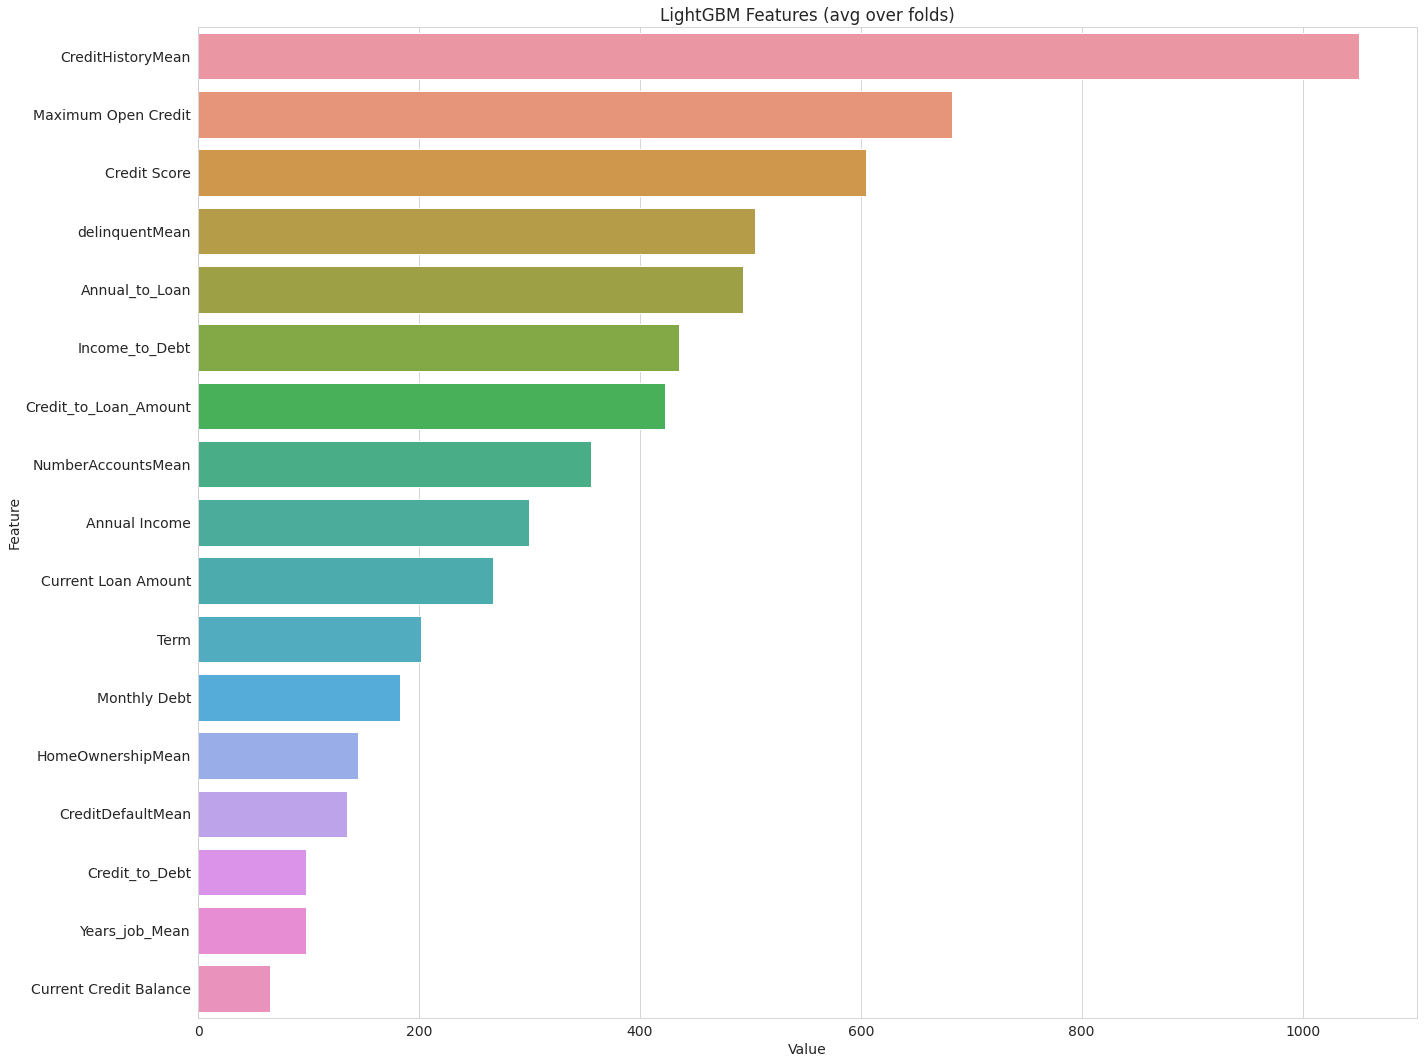

In [443]:
feature_imp = pd.DataFrame(sorted(zip(final_model.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()


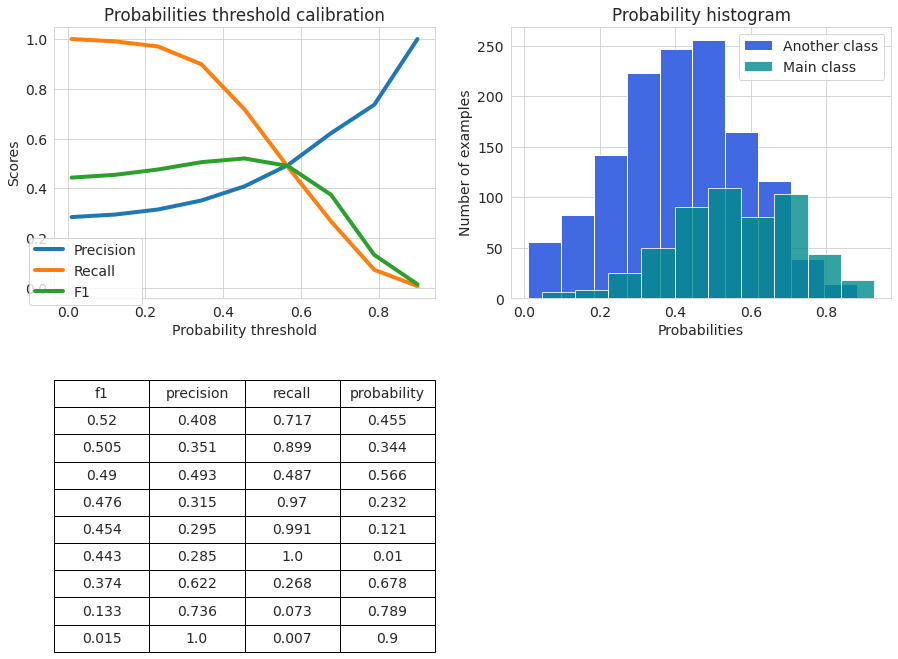

In [444]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

# Прогнозирование на тестовом датасете и сохранение прогноза

In [445]:
test_df.shape

(2500, 17)

In [457]:
predictions = final_model.predict(test_df)
submit = pd.DataFrame(predictions, columns=['Credit Default'])
submit.to_csv('OFedotkin_predictions.csv', index=False)